In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 2. Overview
Distributed Optimization is about how independent agents can optimise a global objective funcion. In the previous chapter we had some variables we need to set, subject to some constraints. Now we look at how good those different solutions are.

## 2.1 Distributed dynamic programming
To illustrate the concepts in distributed dynamic programming we will have a look at path-finding problems. A path finding problem is where you have a directed graph with weighted edges, and want to know the path from one node to another that has the lowest cumulative weight. 

Dynamic programming has a solution to the shortest path problem. If $C(x,y)$ is the minimum cost of getting from node $x$ to node $y$, then $C(x,y)=\min_z C(x,z)+W(z,y)$ where $z$ is an upstream neighbour of $y$ and $W$ is the weight. We then need to know and $C(x,z)$, which can also be broken down in the same way. This leads to Dijkstra's algorithm, where We build up the minimum path from the origin outwards. In the original algorithm the next node calculated is the one with the shortest distance so far.

In [2]:
# first a plotting function:
def plot_directed_graph(nodes,edges,edge_labels=None,pos=None,extra_labels=None):
    """nodes is a list of names. edges is a list of pairs"""
    plt.figure(figsize=(16, 6))
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)
    G.add_edges_from(edges)
    if(pos is None):
        pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='white',edgecolors='black', linewidths=2)
    nx.draw_networkx_edges(G, pos, arrowsize=30, arrows=True,min_source_margin=15, min_target_margin=15)
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='black')    
    if edge_labels is not None:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=15)
    if extra_labels is not None:
        for node, label in extra_labels.items():
            x, y = pos[node]
            plt.text(x, y + 0.35, label, fontsize=15, ha='center', va='bottom',color="red")
    x_values, y_values = zip(*pos.values())
    plt.xlim(min(x_values) - 1, max(x_values) + 1)
    plt.ylim(min(y_values) - 1, max(y_values) + 1)
    plt.show()
    return pos # return the position so that we can reuse it for the next plot.

**Dijstra's algorithm:**

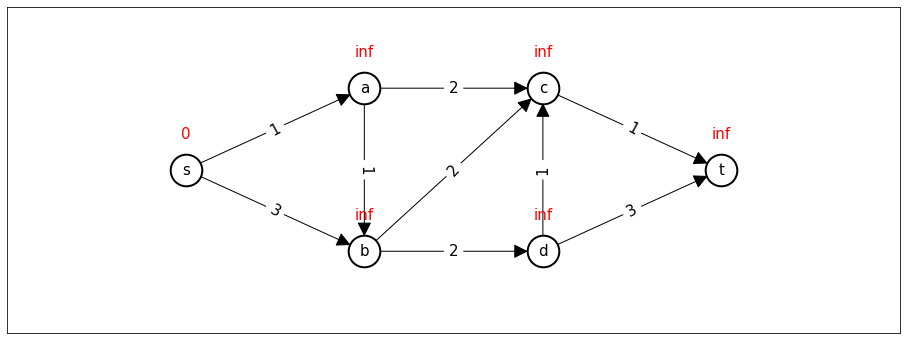

visiting node: s
node s found a new shortest path to a with length 1
node s found a new shortest path to b with length 3


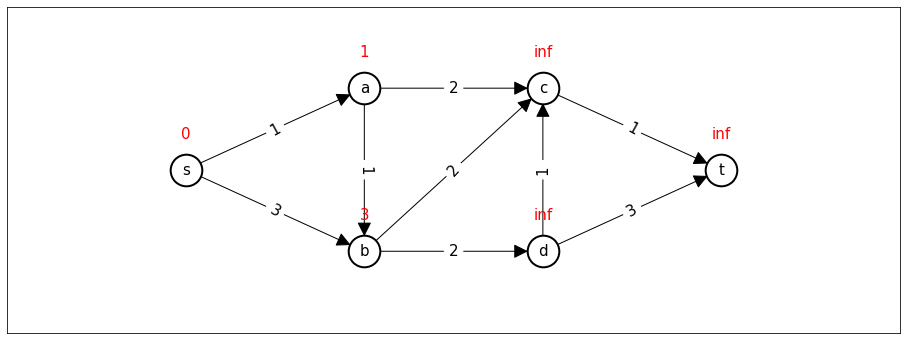

visiting node: a
node a found a new shortest path to b with length 2
node a found a new shortest path to c with length 3


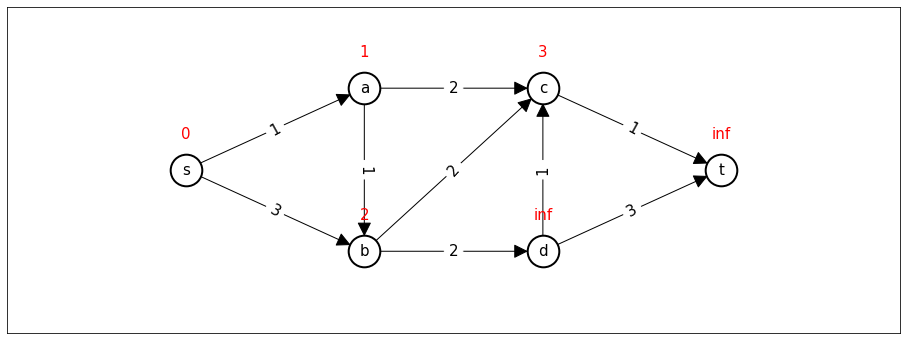

visiting node: b
node b found a new shortest path to d with length 4


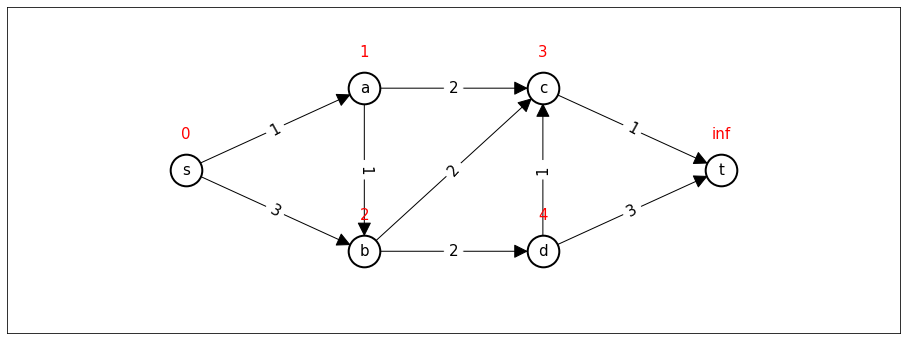

visiting node: c
node c found a new shortest path to t with length 4


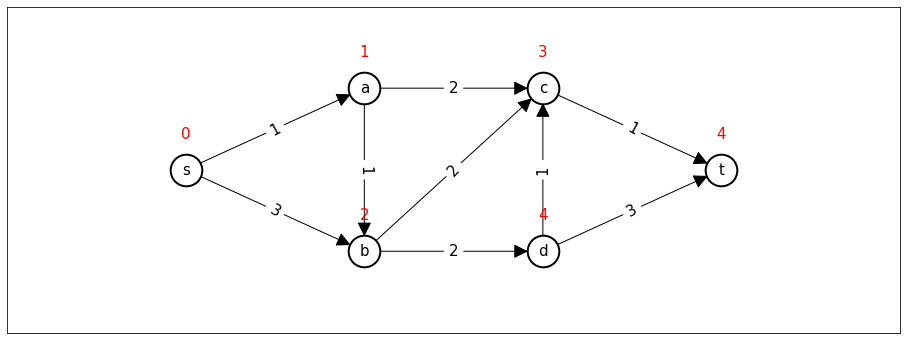

visiting node: d


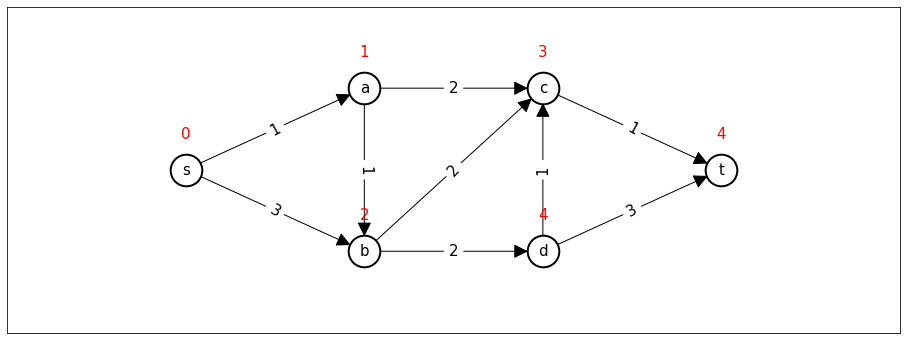

visiting node: t


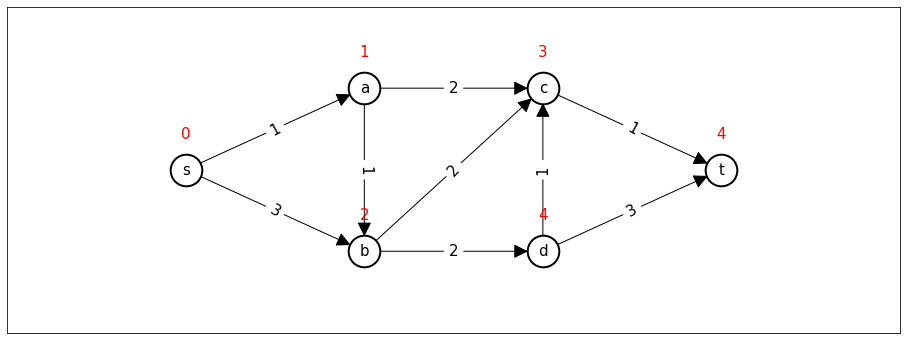

shortest distance is: 4


In [3]:
nodes = ["s","a","b","c","d","t"]
node_pos = {"s":[0,0],"a":[1,1],"b":[1,-1],"c":[2,1],"d":[2,-1],"t":[3,0]}
edges = [("s","a"),("s","b"),("a","b"),("b","c"),("a","c"),("b","d"),("d","c"),("c","t"),("d","t")]
edge_weights = dict(zip(edges,[1,3,1,2,2,2,1,1,3]))
shortest_distances = {"s":0,"a":np.inf,"b":np.inf,"c":np.inf,"d":np.inf,"t":np.inf}

_ = plot_directed_graph(nodes,edges,edge_weights,node_pos,shortest_distances)

# run Dijstra's algorithm. Select a node and update it's downstream neighbours.
visited_nodes = []
while len(visited_nodes)<len(nodes):
    selected_node = None
    shortest_distance = np.inf
    for node in nodes:
        if(shortest_distances[node]<shortest_distance and not node in visited_nodes):
            selected_node = node
            shortest_distance = shortest_distances[node]
    
    print("visiting node:",selected_node)
    
    neighbours = [edge[1] for edge in edges if edge[0]==selected_node]
    for neighbour in neighbours:
        path_weight = shortest_distance + edge_weights[(selected_node,neighbour)]
        if(path_weight<shortest_distances[neighbour]):
            shortest_distances[neighbour] = path_weight
            print("node",selected_node,"found a new shortest path to",neighbour,"with length",path_weight)
    
    visited_nodes.append(selected_node)
    
    _ = plot_directed_graph(nodes,edges,edge_weights,node_pos,shortest_distances)
print("shortest distance is:",shortest_distances["t"])

### 2.1.1 Asynchronous Dynamic Programming
In the Asynchronous version of this algorithm each node updates it's current estimate of it's shortest path repeatedly based on it's currently available neighbours: 

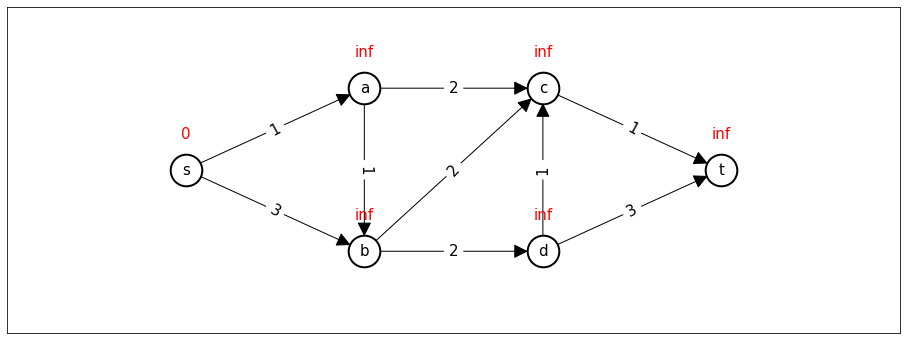

visiting node: c
visiting node: t
visiting node: s
node s found a new shortest path to a with length 1
node s found a new shortest path to b with length 3


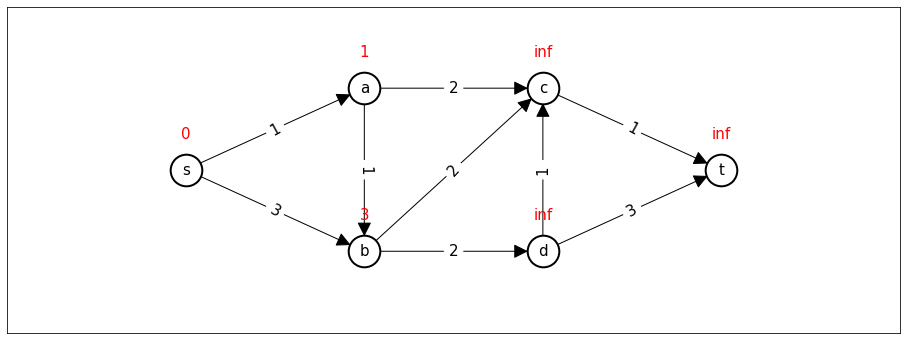

visiting node: s
visiting node: t
visiting node: d
visiting node: d
visiting node: c
visiting node: d
visiting node: t
visiting node: t
visiting node: a
node a found a new shortest path to b with length 2
node a found a new shortest path to c with length 3
visiting node: b
node b found a new shortest path to d with length 4
visiting node: t


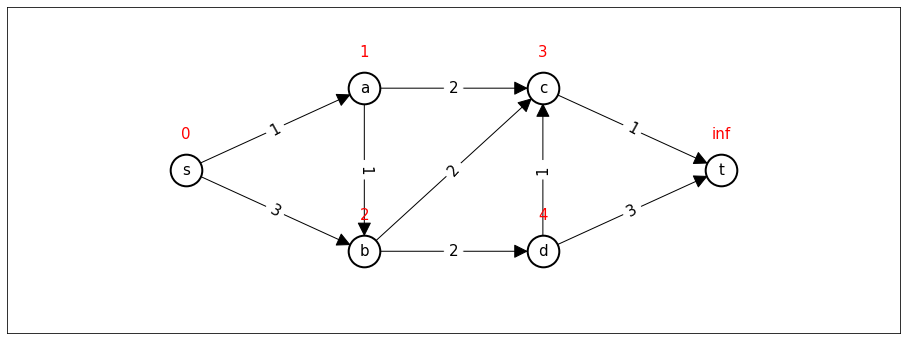

visiting node: t
visiting node: a
visiting node: b
visiting node: t
visiting node: b
visiting node: b
visiting node: c
node c found a new shortest path to t with length 4
visiting node: t


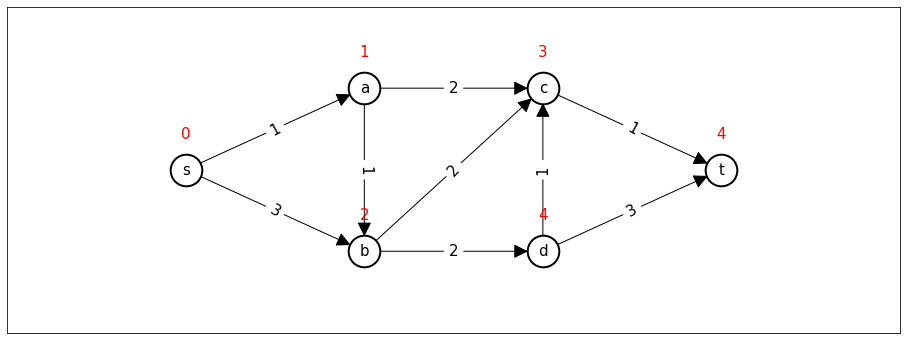

visiting node: b
visiting node: c
visiting node: b
visiting node: d
visiting node: s
visiting node: b
visiting node: s
visiting node: t
visiting node: t
visiting node: d
visiting node: s
visiting node: t
visiting node: a
visiting node: d
visiting node: t
visiting node: d
visiting node: t
visiting node: s
visiting node: b
visiting node: a
visiting node: b
visiting node: b
visiting node: t
visiting node: s
visiting node: c
visiting node: t
visiting node: a
visiting node: c
visiting node: t
visiting node: d
visiting node: s
visiting node: a
visiting node: d
visiting node: d
visiting node: t
visiting node: s
visiting node: s
visiting node: s
visiting node: d
visiting node: a
shortest distance is: 4


In [4]:
nodes = ["s","a","b","c","d","t"]
node_pos = {"s":[0,0],"a":[1,1],"b":[1,-1],"c":[2,1],"d":[2,-1],"t":[3,0]}
edges = [("s","a"),("s","b"),("a","b"),("b","c"),("a","c"),("b","d"),("d","c"),("c","t"),("d","t")]
edge_weights = dict(zip(edges,[1,3,1,2,2,2,1,1,3]))
shortest_distances = {"s":0,"a":np.inf,"b":np.inf,"c":np.inf,"d":np.inf,"t":np.inf}

_ = plot_directed_graph(nodes,edges,edge_weights,node_pos,shortest_distances)

# run the asynchronous algorithm.
for epoch in range(100):
    any_change = False
    for selected_node in nodes:
        if(np.random.rand()<0.1): # add some noise so that we get nodes firing in a random ordering.
            print("visiting node:",selected_node)
            neighbours = [edge[1] for edge in edges if edge[0]==selected_node]
            for neighbour in neighbours:
                shortest_distance = shortest_distances[selected_node]
                path_weight = shortest_distance + edge_weights[(selected_node,neighbour)]
                if(path_weight<shortest_distances[neighbour]):
                    shortest_distances[neighbour] = path_weight
                    print("node",selected_node,"found a new shortest path to",neighbour,"with length",path_weight)
                    any_change = True
    if(any_change):
        _ = plot_directed_graph(nodes,edges,edge_weights,node_pos,shortest_distances)
print("shortest distance is:",shortest_distances["t"])

The problem with this algorithm is that it requires a large number of seperate processes (one for each node). For some problems this is impractical. E.g., imagine finding the shortest number of moves to get from one chess board position to another, where each position is a node.

An alternative is the learning real-time A* algorithm (LRTA*).

### 2.1.2 Learning real-time A*

In this algorithm we have different processes attempting to find a path, and share the information between them. For each node we save an estimate of the distance from that node to the end. It is important this estimate is always less than the truth (e.g,. 0 at first). Each agent then performs a 'trial' where it moves between nodes, selecting the shortest path using the current estimates. At each step they update the estimates. The shortest path estimate of a node $i$ must be at least $\min_j W(i,j)+\text{shortest path estimate}(j)$. If this algorithm finds the same path twice in a row, then it must be the shortest. Why? Well, if there were a shorter path, deviating at some node $j$ instead of $k$, then we must have to incorrectly have an estimate of $\text{shortest path estimate}(j)$ which is larger than the truth. If it were smaller, then we would end up choosing $j$. Because it is not possible to have an estimate larger than the truth this never happens. The estimates are always less than or equal to the truth and only increased when they must be. 

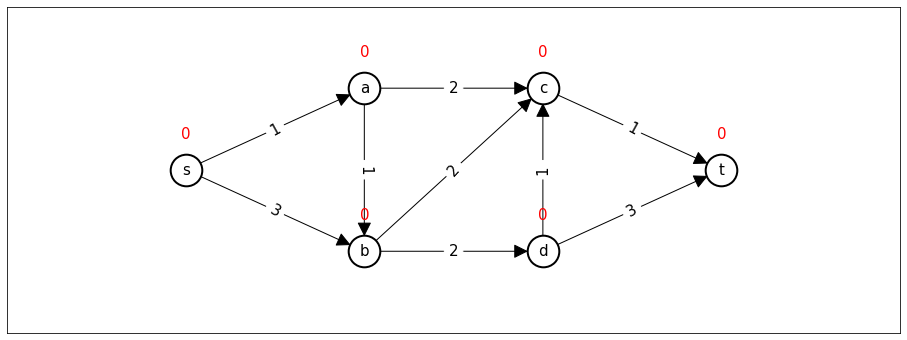

agent 1 - running
agent 1 - node s updated to 1
agent 1 - moved to a


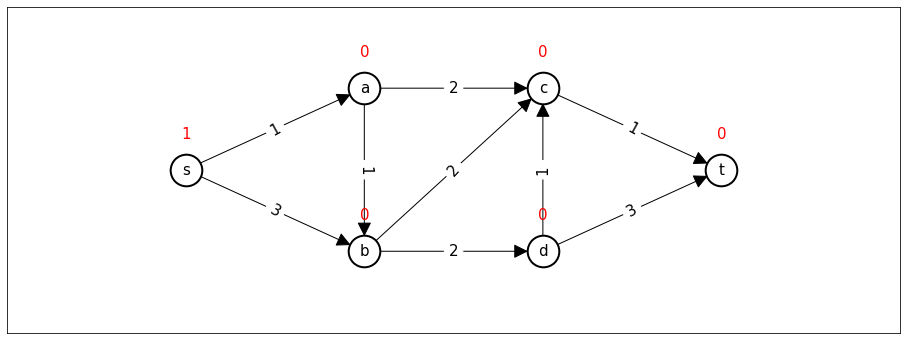

agent 1 - running
agent 1 - node a updated to 1
agent 1 - moved to b
agent 2 - running
agent 2 - node s updated to 2
agent 2 - moved to a


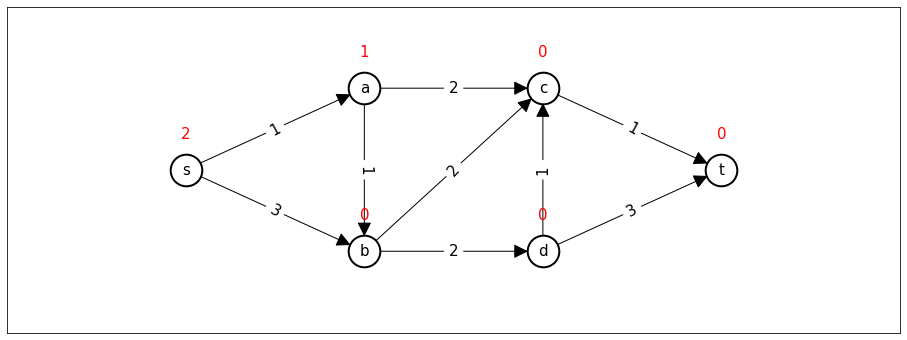

agent 1 - running
agent 1 - node b updated to 2
agent 1 - moved to c
agent 2 - running
agent 2 - node a updated to 2
agent 2 - moved to c


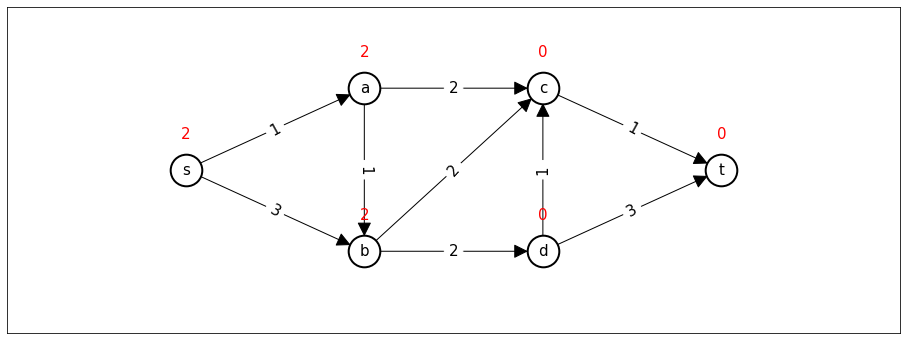

agent 1 - running
agent 1 - node c updated to 1
agent 1 - moved to t


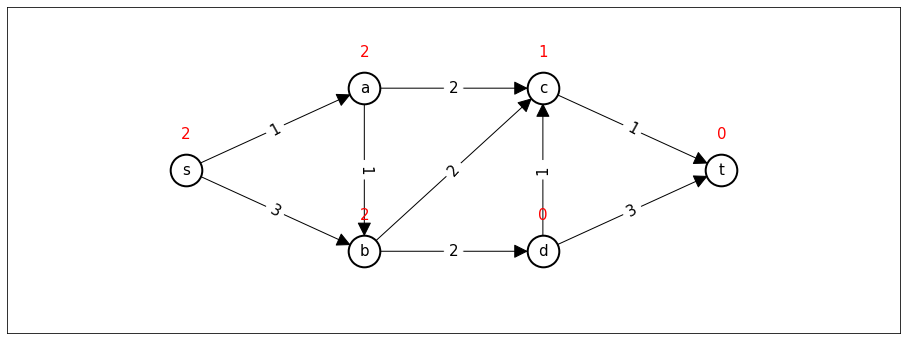

agent 1 - restarted
agent 1 - running
agent 1 - node s updated to 3
agent 1 - moved to a


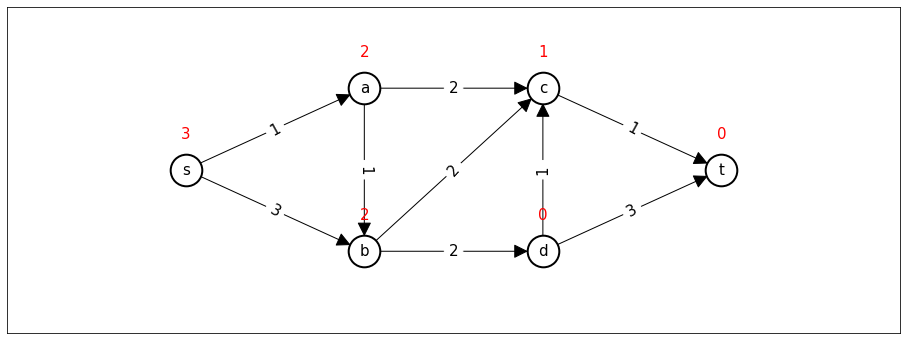

agent 1 - running
agent 1 - node a updated to 3
agent 1 - moved to c


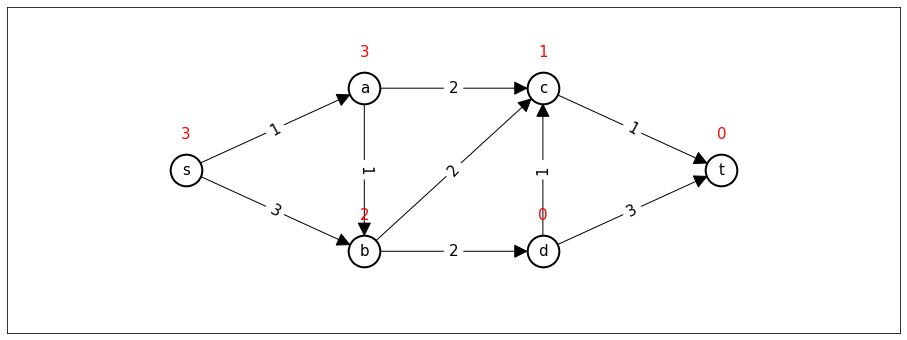

agent 1 - running
agent 1 - moved to t
agent 2 - running
agent 2 - moved to t
agent 2 - restarted
agent 2 - running
agent 2 - node s updated to 4
agent 2 - moved to a


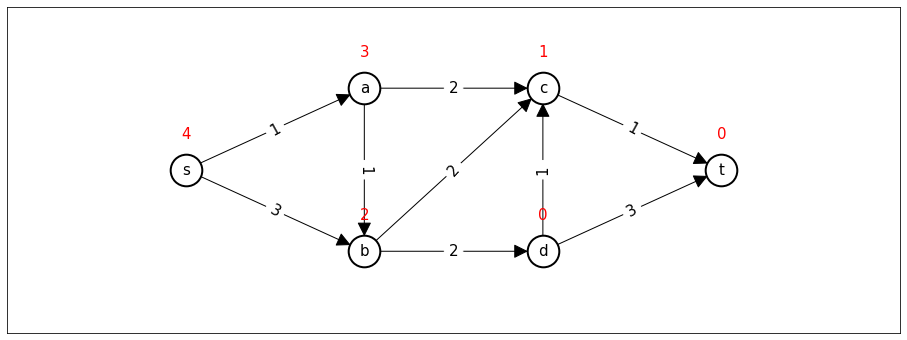

agent 2 - running
agent 2 - moved to b
agent 2 - running
agent 2 - moved to d
agent 2 - running
agent 2 - node d updated to 2
agent 2 - moved to c


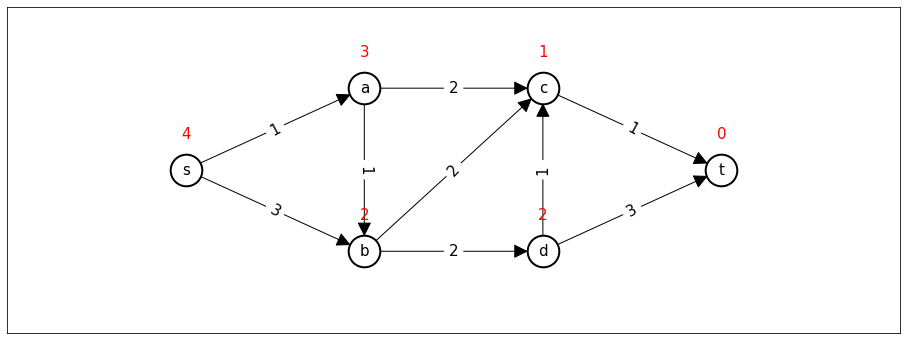

agent 1 - restarted
agent 1 - running
agent 1 - moved to a
agent 2 - running
agent 2 - moved to t
agent 2 - restarted
agent 2 - running
agent 2 - moved to a
agent 1 - running
agent 1 - moved to c
agent 2 - running
agent 2 - moved to b
agent 2 - running
agent 2 - node b updated to 3
agent 2 - moved to c


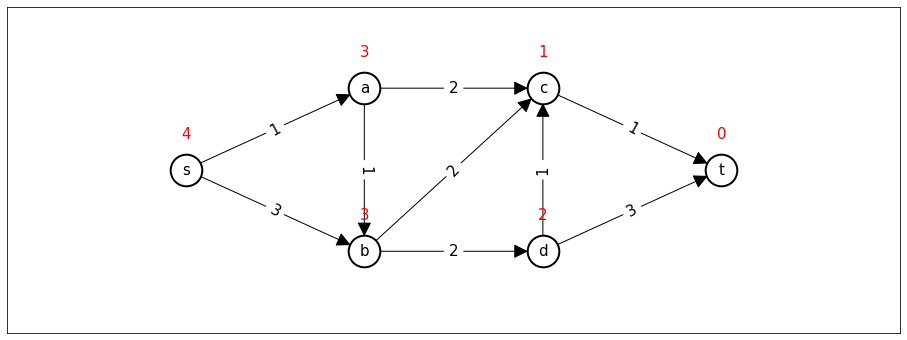

agent 1 - running
agent 1 - moved to t
agent 2 - running
agent 2 - moved to t
agent 1 repeated path sact  twice, terminating
shortest distance is: 4


In [6]:
nodes = ["s","a","b","c","d","t"]
node_pos = {"s":[0,0],"a":[1,1],"b":[1,-1],"c":[2,1],"d":[2,-1],"t":[3,0]}
edges = [("s","a"),("s","b"),("a","b"),("b","c"),("a","c"),("b","d"),("d","c"),("c","t"),("d","t")]
edge_weights = dict(zip(edges,[1,3,1,2,2,2,1,1,3]))
shortest_distance_estimates = {"s":0,"a":0,"b":0,"c":0,"d":0,"t":0}

_ = plot_directed_graph(nodes,edges,edge_weights,node_pos,shortest_distance_estimates)

# run the LRTA* algorithm
number_of_agents = 2
agent_positions = ["s" for n in range(number_of_agents)]
last_paths = ["s" for n in range(number_of_agents)]
current_paths = ["s" for n in range(number_of_agents)]

terminate = False
while not terminate:
    any_updated = False
    for agent_index in range(number_of_agents):
        if(np.random.rand()<0.5): # random chance of updating this node
            current_node = agent_positions[agent_index]
            if(current_node=="t"):
                if(last_paths[agent_index] == current_paths[agent_index]):
                    print("agent",agent_index+1,"repeated path",current_paths[agent_index]," twice, terminating")
                    terminate = True
                    break
                current_node="s" # restart
                last_paths[agent_index] = current_paths[agent_index]
                current_paths[agent_index] = "s"
                print("agent",agent_index+1,"-","restarted")
            
            print("agent",agent_index+1,"-","running")

            neighbours = [edge[1] for edge in edges if edge[0]==current_node]
            shortest_distance = np.inf
            next_node = None
            for neighbour in neighbours:
                total_estimate = shortest_distance_estimates[neighbour] + edge_weights[(current_node,neighbour)]
                if(total_estimate < shortest_distance):
                    shortest_distance = total_estimate
                    next_node = neighbour
                if(total_estimate == shortest_distance): # break ties randomly
                    if(np.random.rand()<0.5):
                        next_node = neighbour

            # if the shortest path estimate is larger, then perform the update
            if shortest_distance>shortest_distance_estimates[current_node]:
                shortest_distance_estimates[current_node] = shortest_distance
                any_updated = True
                print("agent",agent_index+1,"- node",current_node,"updated to",shortest_distance)
            
            agent_positions[agent_index] = next_node
            current_paths[agent_index] = current_paths[agent_index] + next_node
            print("agent",agent_index+1,"-","moved to",next_node)

    if any_updated:
        _ = plot_directed_graph(nodes,edges,edge_weights,node_pos,shortest_distance_estimates)

print("shortest distance is:",shortest_distance_estimates["s"])